---

# University of Liverpool

## COMP534 - Applied AI

---

This notebook is associated with Assignment 1. Use it to complete the assignment by following the instructions provided in each section, which includes a text cell describing the requirements. For additional details, see the Canvas.

In [41]:
# import libraries here
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE


# 1. **Data Management**


In this part, you need to:

1.   analyse and prepare the data. Use plots, graphs, and tables (such as histogram, box plots, scatterplots etc.) to better analyse the dataset and identify issues or potential improvements in the data, including (but not limited to) unnecessary feature/variable which can be dropped/removed, standardization, encoding, etc;
2.   split the data and define your experimental protocol (such as cross-validation or k-fold).

In [42]:
# First reaad in data set and assign valid parameter ranges based on the dataset description
df = pd.read_csv('data/assign1-grades.csv')

valid_school = ['GP', 'MS']
valid_sex = ['F', 'M']
valid_address = ['U', 'R']
valid_famsize = ['GT3', 'LE3']
valid_pstatus = ['T', 'A']
valid_reason = ['home', 'reputation', 'course', 'other']
valid_yes_no = ['yes', 'no']
valid_4scale = np.arange(5)
valid_5scale = np.arange(6)
valid_grade = np.arange(21)

minpass_grade = 12

# Ensure str columns are in the proper case 

upper_columns = ['school', 'sex', 'address', 'famsize', 'Pstatus']
lower_columns = ['reason', 'guardian', 'schoolsup', 'famsup', 'paid',
                 'activities', 'nursery', 'higher', 'internet', 'romantic']

for col in upper_columns:
    df[col] = df[col].str.upper()

for col in lower_columns:
    df[col] = df[col].str.lower()

# Remove null and invalid data 

df = df[df['school'].isin(valid_school)]
df = df[df['sex'].isin(valid_sex)]
df = df[df['address'].isin(valid_address)]
df = df[df['famsize'].isin(valid_famsize)]
df = df[df['Pstatus'].isin(valid_pstatus)]
df = df[df['reason'].isin(valid_reason)]
df = df[df['Grade'].isin(valid_grade)]

scale4 = ['Medu', 'Fedu', 'traveltime', 'studytime']
scale5 = ['famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
yes_no = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
          'internet', 'romantic']

for col in scale4:
    df = df[df[col].isin(valid_4scale)]

for col in scale5:
    df = df[df[col].isin(valid_5scale)]

#print(df[yes_no])
#for col in yes_no:
#    df = df[df[col].isin(valid_yes_no)]

# Create the target column of pass/fail based on min Grade

df['result'] = np.where(df['Grade'] >= minpass_grade, 'pass', 'fail')


Now that the initial validation is complete we can analyse the data set and look for outliers and irrelevant columns

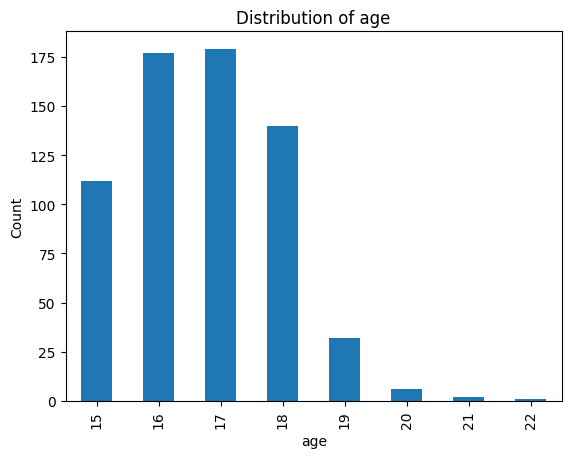

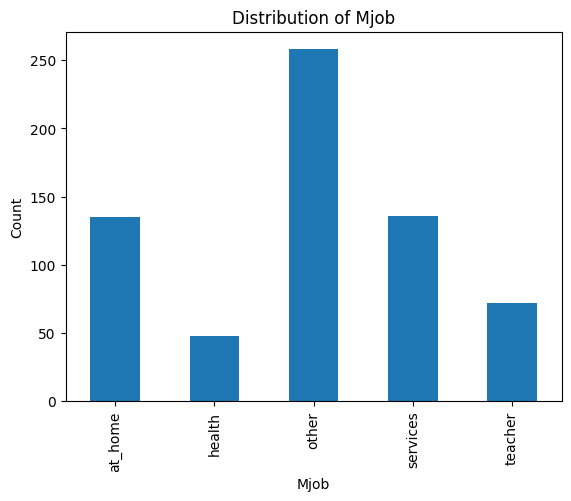

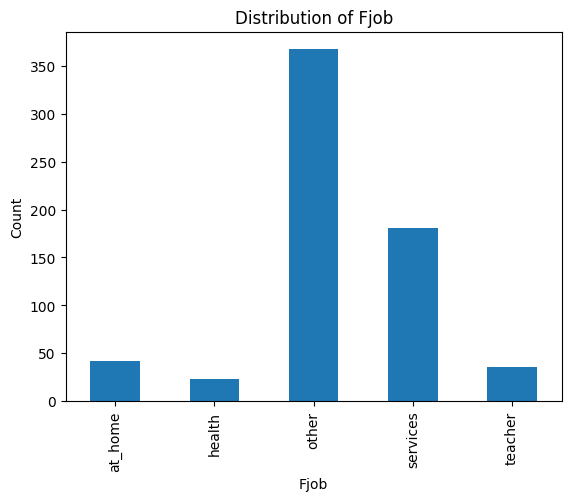

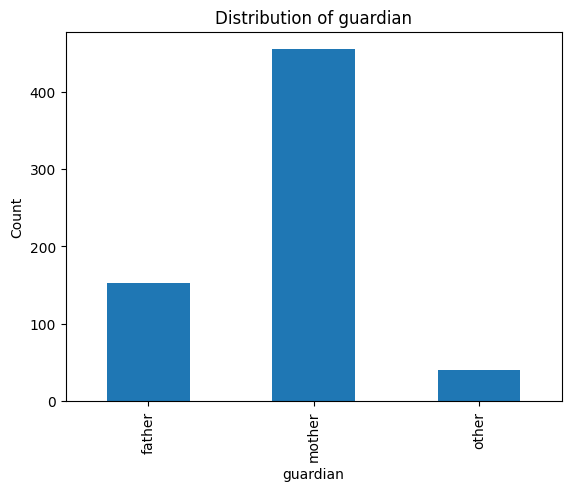

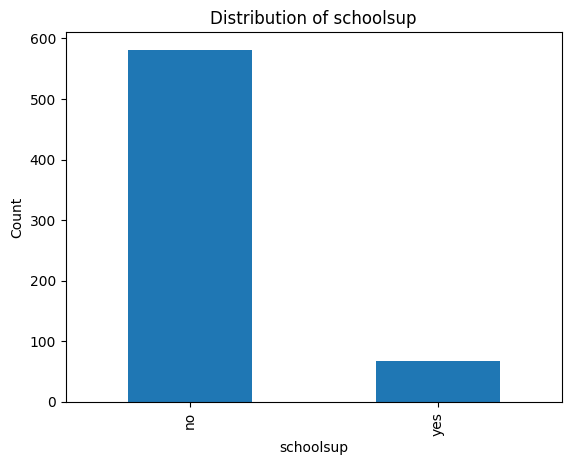

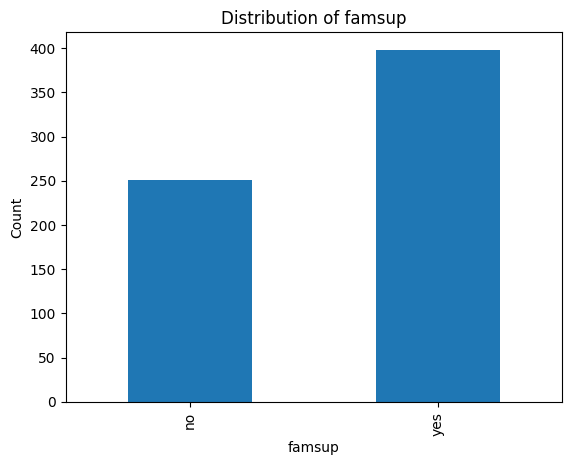

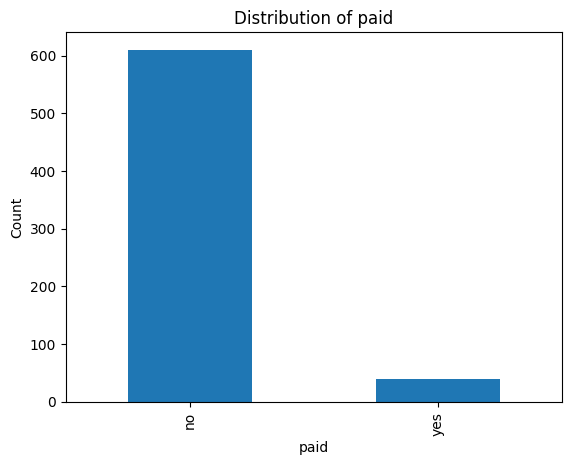

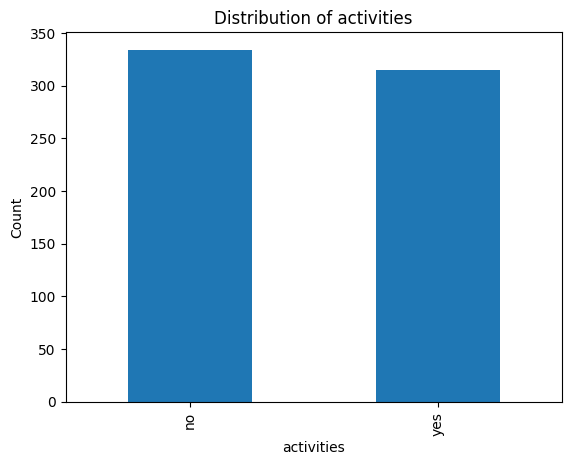

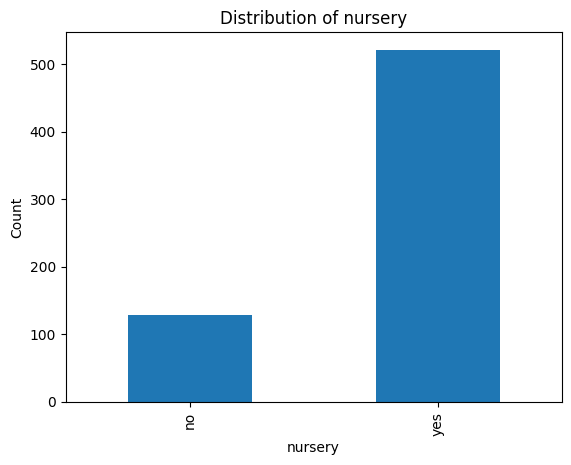

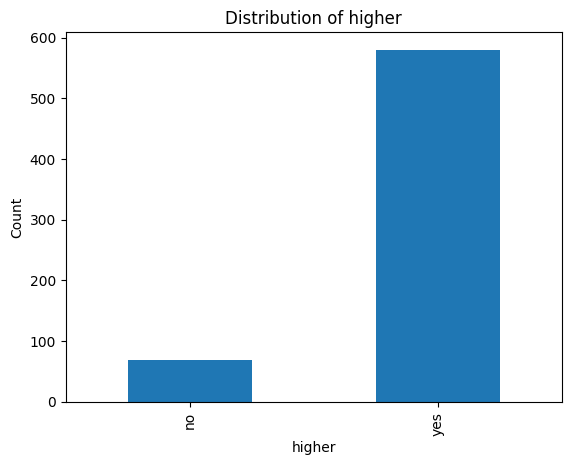

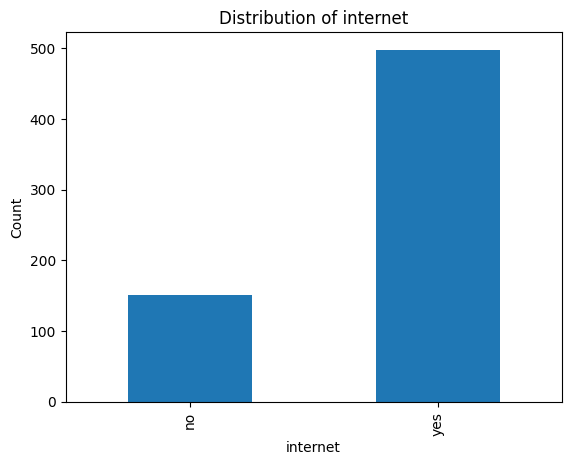

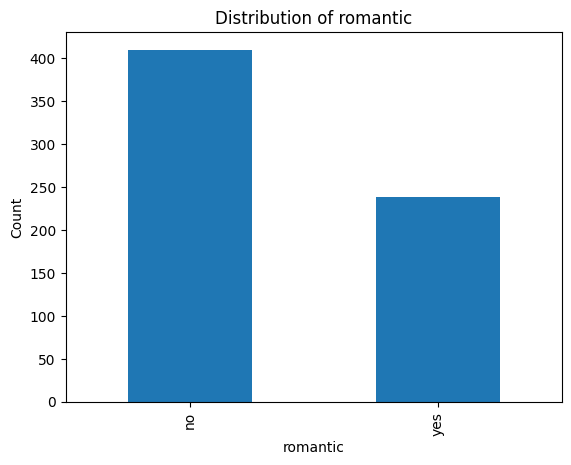

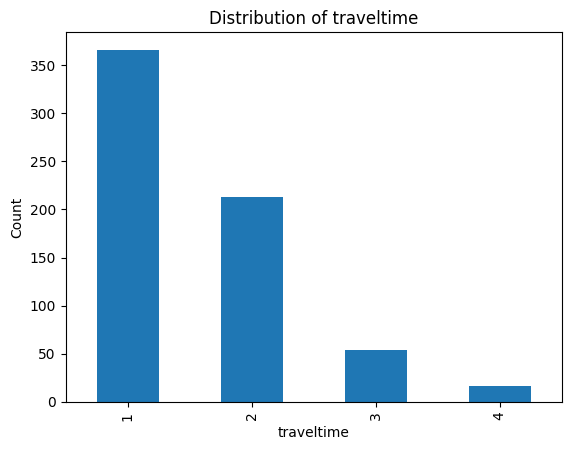

In [43]:
all_column = ['age', 'Mjob', 'Fjob', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'traveltime']
#all_column = df.columns.values()

# Give specific rows counts
for i in all_column:
    value_counts = df[i].value_counts().sort_index()
    #print(value_counts)

# Draw bar chart for each column
for column in all_column:
    data_counts = df[column].value_counts().sort_index()
    plt.figure()
    data_counts.plot(kind='bar')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Distribution of {column}')
    plt.show()

In [44]:
# Remove outliers and unnecessary columns

df = df[df['age'] < 22]
df = df.drop(columns=['paid', 'Grade'])

In [45]:
df_clean = df.drop(columns=["Unnamed: 0"], errors="ignore") # dropping the index column

boolean_columns = ["schoolsup", "famsup", "activities", "nursery", "higher", "internet", "romantic"]
df_clean[boolean_columns] = df_clean[boolean_columns].apply(lambda x: x.map({"yes": 1, "no":0})) #converting boolean data to numerical data representations

binary_columns = ["school", "sex", "address", "famsize", "Pstatus", "result"]
df_encoded = pd.get_dummies(df_clean, columns = binary_columns, drop_first= True ) #one-hot encoded (dummy) variables to handle categorical data

categorical_columns = ["Mjob", "Fjob", "reason", "guardian"]
df_encoded = pd.get_dummies(df_encoded, columns = categorical_columns, drop_first = False)

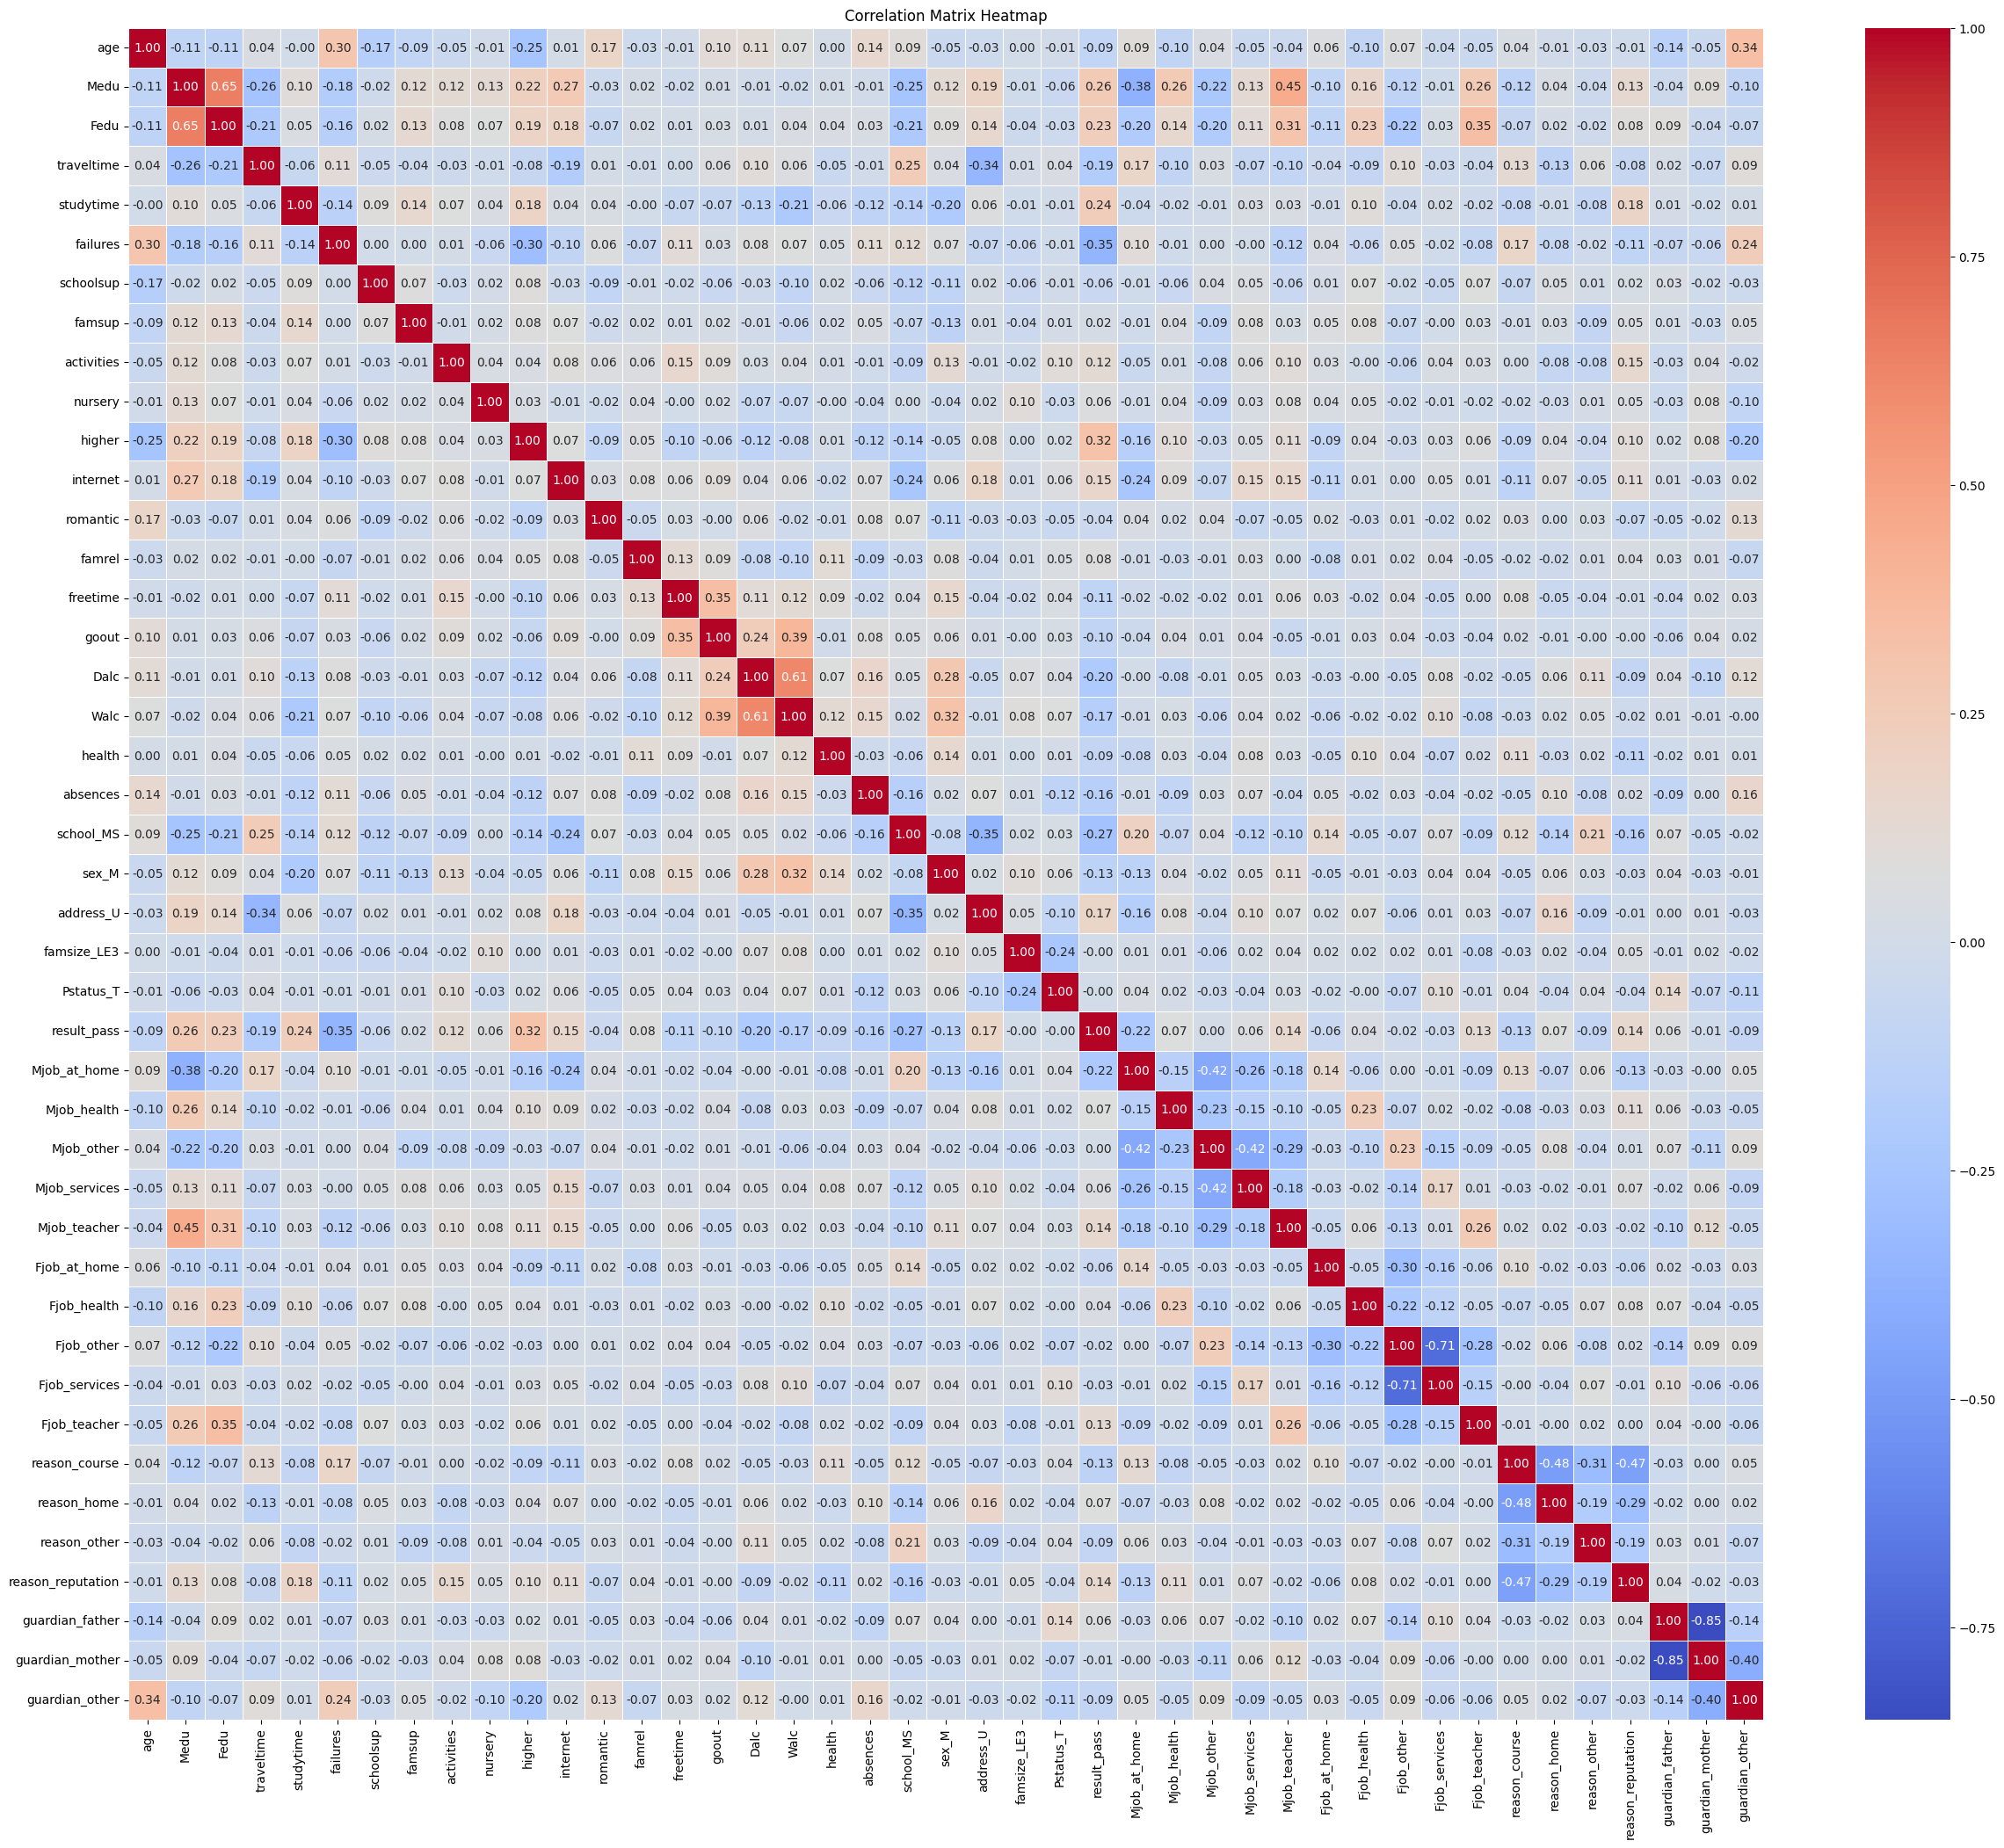

In [46]:
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(30,25))
sns.heatmap (correlation_matrix, cmap= "coolwarm", annot = True, fmt= ".2f", linewidths= 0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [47]:
bool_columns = [
    'school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T',
    'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
    'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 
    'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'result_pass'
    ]

# Converted boolean to numeric (1/0)
df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)

X = df_encoded[['Medu', 'Fedu', 'Mjob_at_home',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services',
       'Fjob_teacher', 'Dalc', 'Walc', 'age','traveltime', 
       'studytime', 'failures', 'schoolsup', 'famsup', 
        'activities', 'nursery', 'higher', 'internet', 'romantic', 
       'famrel', 'freetime', 'goout', 'health', 'absences', 'school_MS', 
       'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T', 'reason_course', 'reason_home', 
       'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other']]
X = sm.add_constant(X)  

y = df_encoded['result_pass']

# Logistic Regression
logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.464689
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:            result_pass   No. Observations:                  648
Model:                          Logit   Df Residuals:                      609
Method:                           MLE   Df Model:                           38
Date:                Tue, 04 Mar 2025   Pseudo R-squ.:                  0.3269
Time:                        12:58:27   Log-Likelihood:                -301.12
converged:                       True   LL-Null:                       -447.38
Covariance Type:            nonrobust   LLR p-value:                 5.034e-41
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.4493        nan        nan        nan         nan         nan
Medu   

In [48]:
# Drop one category from each set of dummies to escape the dummy variables trap
df_vif = df_encoded.drop(columns=[
    "Mjob_other",  
    "Fjob_other",  
    "reason_other",  
    "guardian_other"  
])

X = df_vif.select_dtypes(include=[float, int])

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)



              Feature        VIF
0                 age  78.888633
1                Medu  15.704601
2                Fedu  11.361506
3          traveltime   6.707545
4           studytime   7.944326
5            failures   1.559743
6           schoolsup   1.258890
7              famsup   2.870592
8          activities   2.242537
9             nursery   5.426260
10             higher  11.808060
11           internet   5.338701
12           romantic   1.761763
13             famrel  19.872143
14           freetime  12.419723
15              goout  12.136640
16               Dalc   6.666042
17               Walc   8.729822
18             health   8.004902
19           absences   1.994764
20          school_MS   2.333054
21              sex_M   2.360988
22          address_U   4.290956
23        famsize_LE3   1.618812
24          Pstatus_T   9.569443
25        result_pass   3.366416
26       Mjob_at_home   1.761452
27        Mjob_health   1.549768
28      Mjob_services   1.827087
29       M

In [49]:
df_vif2 = df_vif.drop(columns=[ "famrel", "freetime", "age", "goout", "Medu", "Fedu"]) #Drop columns due to high VIF

X = df_vif2.select_dtypes(include=[float, int])

vif_data2 = pd.DataFrame()
vif_data2["Feature"] = X.columns
vif_data2["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data2)


              Feature        VIF
0          traveltime   6.049723
1           studytime   7.389688
2            failures   1.417683
3           schoolsup   1.255372
4              famsup   2.814950
5          activities   2.177295
6             nursery   5.173270
7              higher  11.392134
8            internet   4.957868
9            romantic   1.702019
10               Dalc   6.459712
11               Walc   7.510087
12             health   7.042648
13           absences   1.901147
14          school_MS   2.156775
15              sex_M   2.250365
16          address_U   4.037646
17        famsize_LE3   1.598502
18          Pstatus_T   8.913836
19        result_pass   3.207895
20       Mjob_at_home   1.666823
21        Mjob_health   1.379313
22      Mjob_services   1.752831
23       Mjob_teacher   1.582685
24       Fjob_at_home   1.216942
25        Fjob_health   1.216004
26      Fjob_services   1.678592
27       Fjob_teacher   1.268562
28      reason_course   4.862204
29        

In [50]:
# Split the data using the 5-fold method 
kfold = KFold(5, shuffle=True, random_state=42)

y = df_encoded['result_pass']
X = df_encoded.drop(columns=['result_pass', 'Medu', 'health'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


---

# 2. **Model Training**

Here, you need to:

1.	select and compare at least three machine learning models (seen/discussed during the lectures) appropriate for your modelling;
2.	if there are hyperparameters in a selected algorithm, define a hyperparameter search protocol (you can define your own), and tune them.


In [573]:
# Implementation of SVM model

# Define our classifier
classifier = svm.SVC()
#X = X.drop(columns=['traveltime'])

# Define hyperparameter grid
param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']},
    {'kernel': ['poly'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
     'degree': [2, 3, 4]}]

# Set up grid search to find the best hyperparams
grid_search = GridSearchCV(classifier, param_grid, cv=kfold,
                           scoring='accuracy', return_train_score=True)

print('Starting grid search to optimise hyperparams')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'best hyperparameters: {best_params}')

best_svm = grid_search.best_estimator_

# Calculate accuracy scores
scores = cross_val_score(best_svm, X_train, y_train, cv=kfold, scoring='accuracy')

average_acc = np.mean(scores)

print(f"Accuracy Score for each fold: {[round(score, 4) for score in scores]}")
print(f"Average accuracy across 5 folds: {average_acc:.2f}")


# Print out scores for each param combo
accuracys = pd.DataFrame(grid_search.cv_results_)
#print(accuracys.columns)
accuracys = accuracys.sort_values('rank_test_score')
print(accuracys[['param_C', 'param_kernel', 'param_gamma', 'param_degree',
                'mean_train_score', 'mean_test_score']])


Starting grid search to optimise hyperparams
best hyperparameters: {'C': 1, 'kernel': 'linear'}
Accuracy Score for each fold: [0.8077, 0.7885, 0.7885, 0.7087, 0.7476]
Average accuracy across 5 folds: 0.77
    param_C param_kernel  ... mean_train_score  mean_test_score
1       1.0       linear  ...         0.787146         0.768185
2      10.0       linear  ...         0.785221         0.762323
0       0.1       linear  ...         0.783779         0.760493
21     10.0         poly  ...         0.816113         0.750822
15      1.0         poly  ...         0.765926         0.743148
6       1.0          rbf  ...         0.810805         0.743055
22     10.0         poly  ...         0.846033         0.741113
5       1.0          rbf  ...         0.794876         0.739171
23     10.0         poly  ...         0.816118         0.737323
7      10.0          rbf  ...         0.853279         0.737155
18      1.0         poly  ...         0.805498         0.735437
16      1.0         poly  .

In [574]:
# Implementation of RandomForest Model

# Read the dataset
df = pd.read_csv('data/df_vif_cleaned.csv')

# Separate features (x) and target (y)
x = df.drop(columns=['result_pass'])
y = df['result_pass']

# Define K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for tuning
param_grid = {
    "n_estimators": [100, 200, 300],          # Number of trees
    "max_depth": [10, 20, None],              # Tree depth limit
    "min_samples_split": [2, 5, 10],          # Minimum samples to split a node
    "min_samples_leaf": [1, 2, 4],            # Minimum samples per leaf
    "max_features": ["sqrt", "log2"]          # Features considered per split
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=kf, scoring="accuracy")
grid_search.fit(x, y)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best Cross-Validation Accuracy: 0.744221824686941


In [52]:
# Implementation of Logistic Regression Model
df = pd.read_csv('data/df_vif_cleaned.csv')

# Columns dropped due to feature importance as seen in Logistic_Regression.ipynb
df2 = df.drop(columns = [ 'famsup', 'Fjob_health', 'Pstatus_T', 'nursery', 'reason_reputation', 'romantic', 'Walc', 'guardian_father', 'Mjob_health', 'Mjob_services', 'reason_course', 
                         'reason_reputation'])

# Feature Engineering to adjust weighting
df2['studytime_failures'] = df2['studytime'] * df2['failures']
df2['paid_schoolsup'] = df2['paid'] * df2['schoolsup']
df2['health_absences'] = df2['health'] * df2['absences']
df2['absences_studytime'] = df2['absences'] * df2['studytime']
df2['Dalc_health'] = df2['Dalc'] * df2['health']
df2['traveltime_schoolsup'] = df2['traveltime'] * df2['schoolsup']

# Columns dropped due to noise as seen in Logistic_Regression.ipynb 
X = df2.drop(columns=['result_pass', 'health_absences', 'paid_schoolsup', 'internet', 'Dalc_health', 'absences', 'famsize_LE3', 
                      'traveltime', 'higher'])
y = df2['result_pass']

# SMOTE used to boost recall score for class 0 (fail), due to slight imbalance by creating synthetic examples
smote = SMOTE(random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'penalty': ['l1', 'l2'],                    #l1 (Lasso), l2 (Ridge)
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'solver': ['liblinear', 'saga'],  
    'max_iter': [10000]  
}

best_params = None
best_score = 0
accuracies = []
conf_matrices = []
class_reports = []

for train_index, val_index in kf.split(X, y):
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    model = LogisticRegression()
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,  
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train_smote, y_train_smote)

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_

    best_model = grid_search.best_estimator_
    best_model.fit(X_train_smote, y_train_smote)

    y_pred = best_model.predict(X_val)
    
    accuracies.append(accuracy_score(y_val, y_pred))
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    class_reports.append(classification_report(y_val, y_pred, output_dict=True))

avg_accuracy = np.mean(accuracies)
avg_conf_matrix = np.mean(conf_matrices, axis=0)
avg_class_report = np.mean([report['accuracy'] for report in class_reports])

df_results = pd.DataFrame(grid_search.cv_results_)

top_10_results = df_results[['param_penalty', 'param_C', 'param_solver', 
                             'mean_test_score', 'std_test_score', 'rank_test_score']]\
                    .sort_values(by='rank_test_score')\
                    .head(10)

print(f"Best Hyperparameters: {best_params}")
print(f"Best Training Accuracy: {best_score:.4f}")
print(f"Average Test Accuracy: {avg_accuracy:.4f}")
print("Average Confusion Matrix:\n", avg_conf_matrix)
print("Average Classification Report (accuracy): {:.4f}".format(avg_class_report))
print("\nTop 10 Hyperparameter Configurations:\n", top_10_results)




Best Hyperparameters: {'C': 0.01, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
Best Training Accuracy: 0.7389
Average Test Accuracy: 0.7426
Average Confusion Matrix:
 [[41.  19.2]
 [14.2 55.4]]
Average Classification Report (accuracy): 0.7426

Top 10 Hyperparameter Configurations:
    param_penalty  param_C param_solver  mean_test_score  std_test_score  \
6             l2     0.01    liblinear         0.738940        0.041468   
7             l2     0.01         saga         0.731583        0.032280   
10            l2     0.10    liblinear         0.718451        0.089592   
11            l2     0.10         saga         0.714747        0.098449   
14            l2     1.00    liblinear         0.698165        0.106533   
15            l2     1.00         saga         0.696330        0.106612   
13            l1     1.00         saga         0.694495        0.107131   
16            l1    10.00    liblinear         0.692644        0.107727   
19            l2    10.00   

---

# 3. **Evaluate models**

Here, you need to:

1.	test the model (the best one you obtained from the above stage) on the testing dataset.


In [278]:
# Write your proposed solution code here. Create more code cells if you find it necessary

best_model = best_svm

y_pred = best_model.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.7538461538461538
